<p style="color:RoyalBlue;font-size:30pt"> Demografía</p>

Este cuaderno de Jupyter contiene código de Python para crear gráficos y mapas que ilustren estadísticas demográficas.

Fue creado para generar el material complementario del tema "Población" del curso **EC3300 Crecimiento Económico** de la Universidad de Costa Rica.

Randall Romero Aguilar

*Agosto-septiembre de 2021*

# Preparativos
## Importar paquetes y definir algunas opciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import world_bank_data as wb
import geopandas

# Opciones para gráficos
plt.style.use('seaborn-dark')
plt.rc('savefig', bbox='tight')
plt.rc('axes', titlesize=18, labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('savefig', bbox='tight')

%matplotlib inline

In [2]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [3]:
grupos = ['WLD','CRI', 'HIC','MIC','LIC']  # regiones para las cuales queremos indicadores

opciones_grupos = dict(simplify_index=True, country=grupos, id_or_value=True)
opciones_paises = dict(simplify_index=True, id_or_value=True)

## Definir varias funciones auxiliares
Estas funciones facilitarán la creación de los gráficos y mapas

In [4]:
def datos_grupos(indicador):
    return wb.get_series(indicador, **opciones_grupos).unstack().T

In [5]:
def graficar_indicador(df, ax, color_grupos=False):
    df[grupos[:2]].plot(lw=3,ax=ax)
    if color_grupos:
        df[grupos[2:]].plot(ax=ax)
    else:
        df[grupos[2:]].plot(ax=ax, color='gray')
    return ax

In [6]:
def crear_map(indicador, db, titulo, leyenda, cmap='RdGy',**kwargs):
    temp = pd.merge(world, db, left_on='iso_a3', right_index=True)
    
    fig, axs = plt.subplots(2,1,figsize=[14,8], gridspec_kw=dict(height_ratios=[12,1],hspace=-0.2))
    temp.plot(column=indicador, 
              cmap=cmap, 
              ax=axs[0],
              cax=axs[1],
              legend=True,
              legend_kwds={'label': leyenda, 'orientation': "horizontal"},
             **kwargs)
    axs[0].set_facecolor('LightBlue')
    axs[0].set(xticks=[], yticks=[], title=titulo);
    return fig, axs

# Crear gráficos y mapas

## Esperanza de vida al nacer

### Tendencias

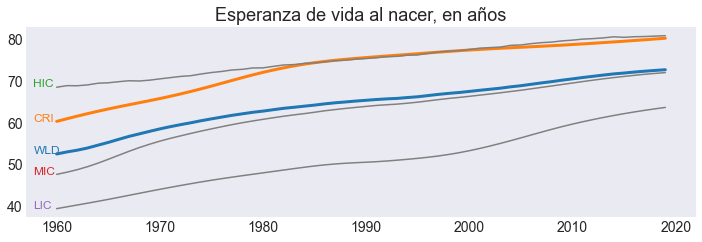

In [7]:
fig, ax = plt.subplots(figsize=[12,3.5])

LE00 = datos_grupos('SP.DYN.LE00.IN')

graficar_indicador(LE00, ax)
for i, gr in enumerate(grupos):
    ax.annotate(gr, (-2.25, LE00.loc['1960', gr]), fontsize=12, color=f'C{i}')

ax.legend([])
ax.set_xlabel('')
ax.set_title('Esperanza de vida al nacer, en años')
fig.savefig('life_expectancy.pdf')

### Mapa

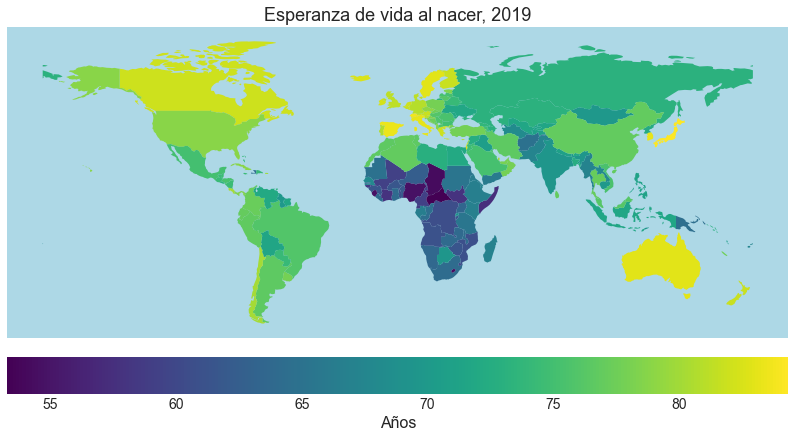

In [8]:
esperanza_vida = wb.get_series('SP.DYN.LE00.IN', **opciones_paises).unstack()[["2019"]]
fig, axs = crear_map('2019', esperanza_vida,'Esperanza de vida al nacer, 2019', "Años", cmap="viridis")
fig.savefig('map-life_expectancy.pdf')

## RNI, CBR, CDR

### Tendencias

In [9]:
transi = pd.concat([wb.get_series(indic, **opciones_grupos) for indic in ['SP.DYN.CBRT.IN','SP.DYN.CDRT.IN']], axis=1)
transi.rename(columns={'SP.DYN.CBRT.IN':'CBR','SP.DYN.CDRT.IN':'CDR'}, inplace=True)
transi.eval("RNI = CBR-CDR", inplace=True)
transi = transi.unstack(level=0)

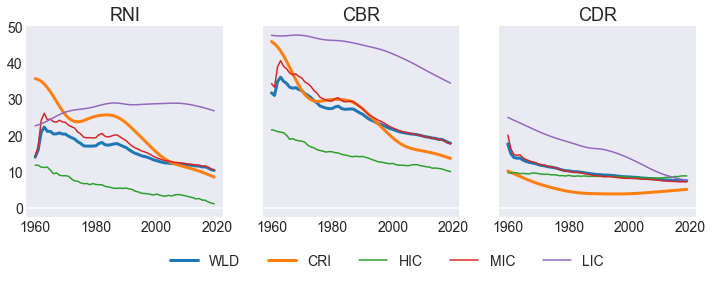

In [10]:
fig, axs = plt.subplots(1,3, figsize=[12,3.5], sharey=True)

for ind, ax in zip(['RNI', 'CBR','CDR'], axs):
    graficar_indicador(transi[ind], ax, True)
    ax.set_xlabel('')
    ax.set_title(ind, fontsize=18)
    ax.axhline(0, color='w')

axs[0].legend([])
axs[2].legend([])
axs[1].legend(grupos,loc=[-0.5,-0.3],ncol=5, fontsize=14)

   
fig.savefig('RNI-CBR-CDR.pdf')

### Mapas

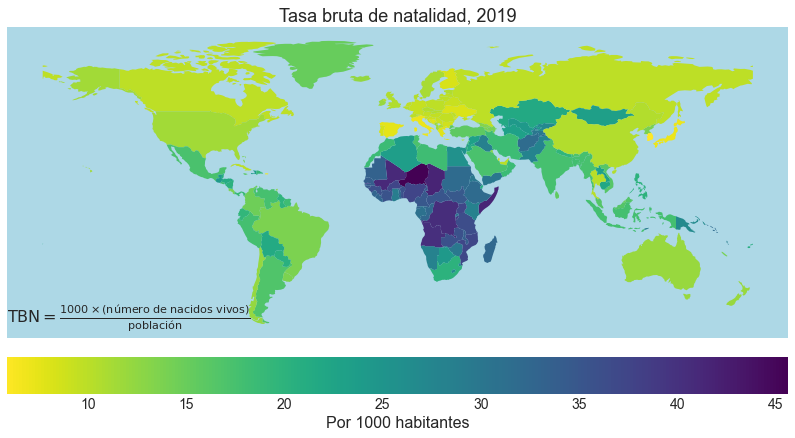

In [11]:
CBR = wb.get_series('SP.DYN.CBRT.IN', **opciones_paises).unstack()[["2019"]]
fig, axs = crear_map('2019', CBR,'Tasa bruta de natalidad, 2019', "Por 1000 habitantes", cmap="viridis_r")
axs[0].annotate(r'$\mathrm{TBN}= \frac{1000 \times \mathrm{(número\;de\;nacidos\;vivos)}}{\mathrm{población}}$', 
                (0.0,0.05),  xycoords='axes fraction', fontsize=16)

fig.savefig('map-CBR.pdf')

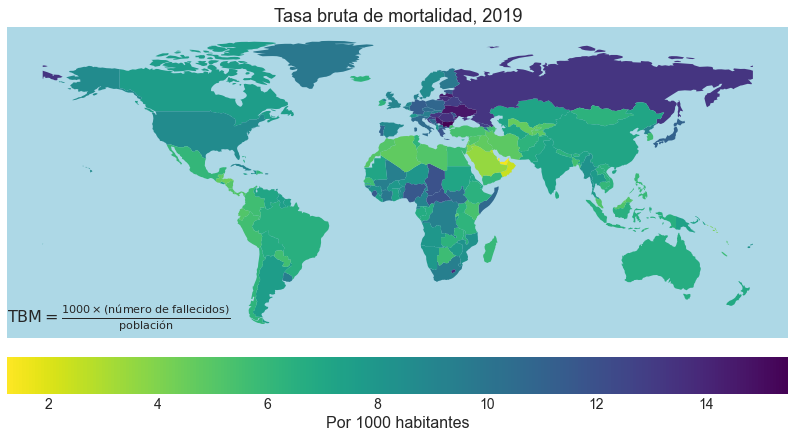

In [12]:
CDR = wb.get_series('SP.DYN.CDRT.IN', **opciones_paises).unstack()[["2019"]]
fig, axs = crear_map('2019', CDR,'Tasa bruta de mortalidad, 2019', "Por 1000 habitantes", cmap="viridis_r")
axs[0].annotate(r'$\mathrm{TBM}= \frac{1000 \times \mathrm{(número\;de\;fallecidos)}}{\mathrm{población}}$', 
                (0.0,0.05),  xycoords='axes fraction', fontsize=16)
fig.savefig('map-CDR.pdf')

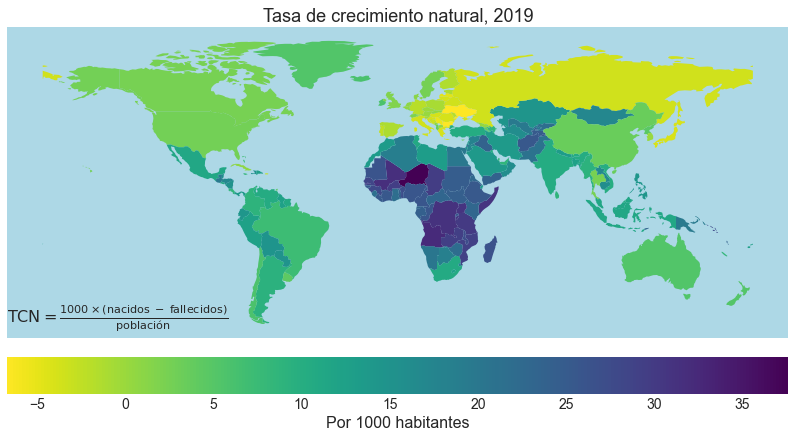

In [13]:
fig, axs = crear_map('2019', CBR-CDR,'Tasa de crecimiento natural, 2019', "Por 1000 habitantes", cmap="viridis_r")
axs[0].annotate(r'$\mathrm{TCN}= \frac{1000 \times \mathrm{(nacidos\;-\;fallecidos)}}{\mathrm{población}}$', 
                (0.0,0.05),  xycoords='axes fraction', fontsize=16)
fig.savefig('map-RNI.pdf')

## Tasa de fertilidad

### Tendencias

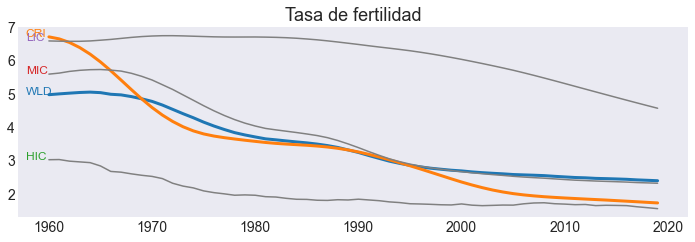

In [14]:
fig, ax = plt.subplots(figsize=[12,3.5])
FR = wb.get_series('SP.DYN.TFRT.IN', **opciones_grupos).unstack().T

graficar_indicador(FR, ax=ax)


for i, gr in enumerate(grupos):
    ax.annotate(gr, (-2.25, FR.loc['1960', gr]), fontsize=12, color=f'C{i}')

ax.legend([])
ax.set_xlabel('')
ax.set_title('Tasa de fertilidad')
fig.savefig('fertility-rate.pdf')

### Mapa

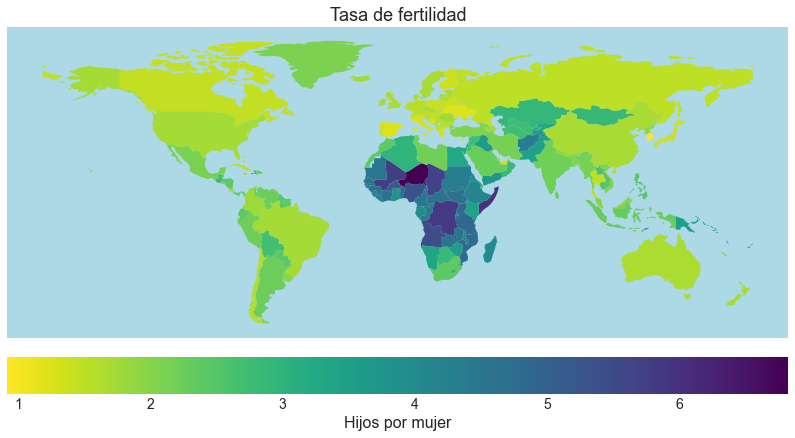

In [15]:
fertilidad = wb.get_series('SP.DYN.TFRT.IN', **opciones_paises).unstack()[["2019"]]
fig, axs = crear_map('2019', fertilidad,'Tasa de fertilidad', "Hijos por mujer", cmap="viridis_r")
fig.savefig('map-fertility-rate.pdf')

## Mortalidad infantil

### Tendencias

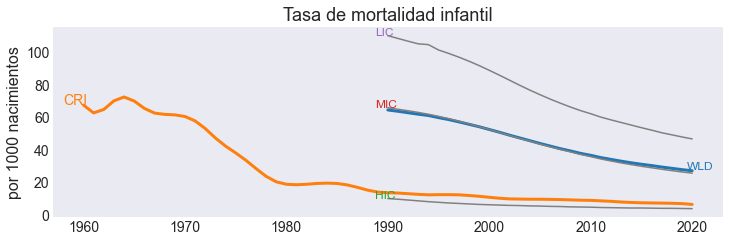

In [16]:
fig, ax = plt.subplots(figsize=[12,3.5])
IMR = wb.get_series('SP.DYN.IMRT.IN', **opciones_grupos).unstack().T

graficar_indicador(IMR, ax)

ax.annotate('WLD', (59.5, IMR.loc['2019', 'WLD']), fontsize=12, color='C0')
ax.annotate('CRI', (-2, IMR.loc['1960', 'CRI']), fontsize=14, color='C1')

for i, gr in enumerate(grupos[2:], 2):
    ax.annotate(gr, (28.75, IMR.loc['1990', gr]), fontsize=12, color=f'C{i}')

ax.legend([])
ax.set(xlabel='', 
       ylabel='por 1000 nacimientos', 
       title='Tasa de mortalidad infantil')
fig.savefig('infant-mortality-rate.pdf')

### Mapa

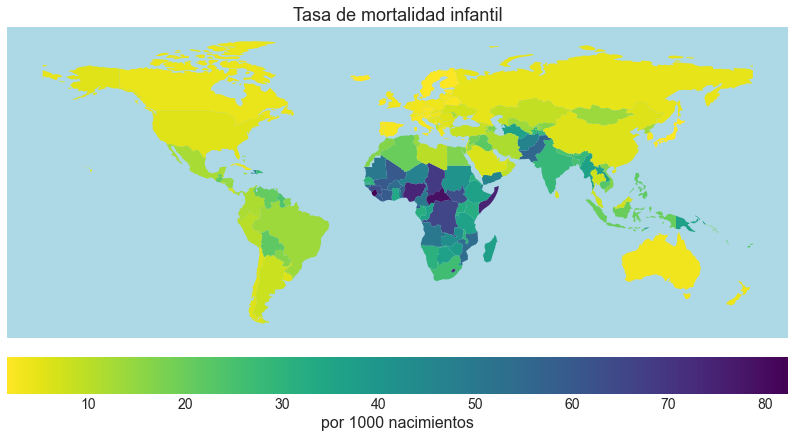

In [17]:
mortalidad_infantil = wb.get_series('SP.DYN.IMRT.IN', **opciones_paises).unstack()[["2019"]]

fig, axs = crear_map('2019', mortalidad_infantil,'Tasa de mortalidad infantil', "por 1000 nacimientos", cmap="viridis_r")
fig.savefig('map-infant-mortality-rate.pdf')

## Perfil de edad

### Tendencias

In [18]:
indicadores = ['SP.POP.0014.TO.ZS', 'SP.POP.1564.TO.ZS', 'SP.POP.65UP.TO.ZS']

In [19]:
poblacion = pd.concat([wb.get_series(indic, **opciones_grupos) for indic in indicadores], axis=1)

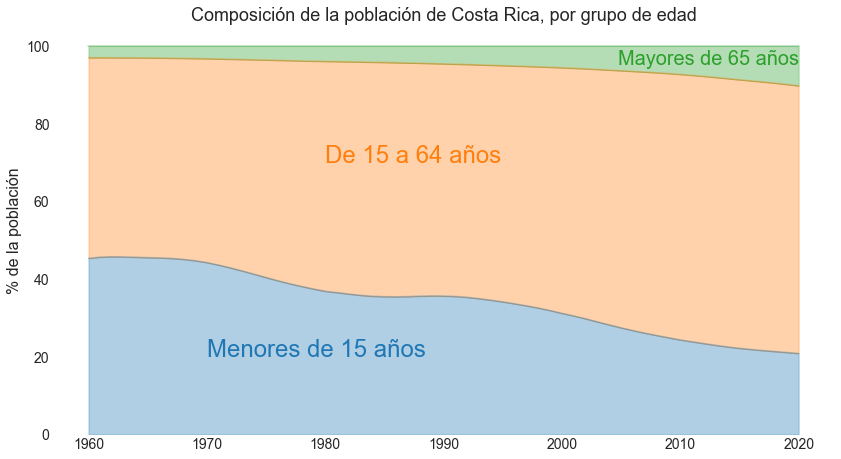

In [20]:
fig, ax = plt.subplots(figsize=[14,7.5])
poblacion.loc['CRI'].plot.area(ax=ax, alpha=0.35)

ax.legend([])
ax.annotate('Menores de 15 años', (10, 20), color='C0', fontsize=24)
ax.annotate('De 15 a 64 años', (20, 70), color='C1', fontsize=24)
ax.annotate('Mayores de 65 años', (60, 99), color='C2', fontsize=20, ha='right', va='top')
ax.set(
    xlabel='', 
    ylabel='% de la población', 
    facecolor='white',
    title="Composición de la población de Costa Rica, por grupo de edad"
      )
fig.savefig('poblacion-por-edad-costa-rica.pdf')

[Text(0.5, 0, ''),
 Text(0, 0.5, '% de la población'),
 None,
 Text(0.5, 1.0, 'Composición de la población mundial, por grupo de edad')]

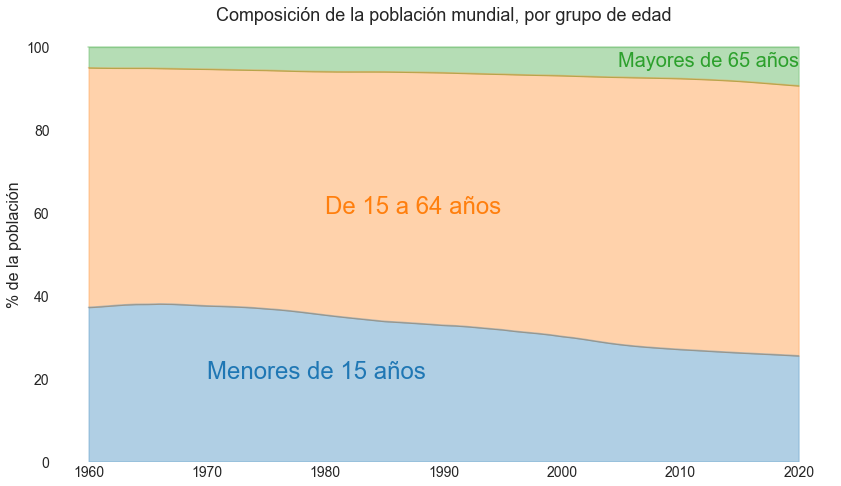

In [21]:
fig, ax = plt.subplots(figsize=[14,8])
poblacion.loc['WLD'].plot.area(ax=ax, alpha=0.35)

ax.legend([])
ax.annotate('Menores de 15 años', (10, 20), color='C0', fontsize=24)
ax.annotate('De 15 a 64 años', (20, 60), color='C1', fontsize=24)
ax.annotate('Mayores de 65 años', (60, 99), color='C2', fontsize=20, ha='right', va='top')
ax.set(
    xlabel='', 
    ylabel='% de la población', 
    facecolor='white',
    title="Composición de la población mundial, por grupo de edad"
      )

In [22]:
poblacion2 = poblacion.loc[grupos[2:]].swaplevel(axis=0).loc[["1960", "2020"],].swaplevel().sort_index()

In [23]:
poblacion2

SP.POP.0014.TO.ZS  SP.POP.1564.TO.ZS  SP.POP.65UP.TO.ZS
Country Year                                                         
HIC     1960          28.971023          62.376269           8.652708
        2020          16.321492          65.032675          18.645833
LIC     1960          42.699275          54.308860           2.991865
        2020          41.719228          55.014362           3.266410
MIC     1960          39.708796          56.498394           3.792809
        2020          25.528200          66.391109           8.080691

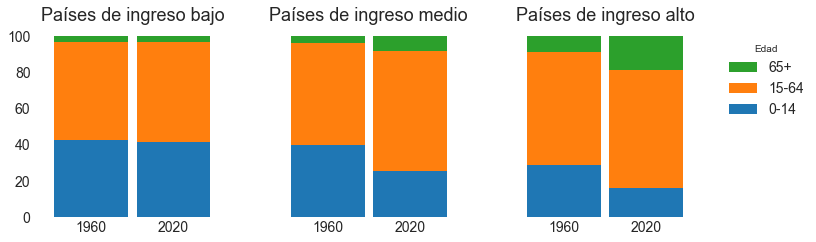

In [24]:
options=dict(kind='bar',stacked=True, width=0.9)

fig, axs = plt.subplots(1,3,figsize=[12,3.5], sharey=True)
poblacion2.loc['LIC'].plot(ax=axs[0], title='Países de ingreso bajo', **options)
poblacion2.loc['MIC'].plot(ax=axs[1], title='Países de ingreso medio', **options)
poblacion2.loc['HIC'].plot(ax=axs[2], title='Países de ingreso alto', **options)

for ax in axs:
    ax.set_xlabel('')
    ax.set_facecolor('white')
    ax.legend([])
    ax.set_xticklabels(['1960','2020'], rotation=0)

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(reversed(handles), reversed(['0-14', '15-64', '65+']), title='Edad', loc=[1.1,0.5], fontsize=14);
fig.savefig('age-profile.pdf')

In [25]:
POP = wb.get_series('SP.POP.GROW', simplify_index=True, country=grupos).unstack().T

## Migración

### Tendencias

In [26]:
NETM = wb.get_series('SM.POP.NETM', simplify_index=True, id_or_value=True).unstack()

In [27]:
migracion = NETM.dropna(how='all', axis=1).loc[grupos[2:]]
migracion

Year,1962,1967,1972,1977,1982,1987,1992,1997,2002,2007,2012,2017
Country,,,,,,,,,,,,
HIC,3985806.0,4273813.0,7286263.0,7394923.0,6745191.0,8494971.0,10812939.0,14016794.0,18650629.0,23370108.0,18276013.0,16158522.0
MIC,-3535532.0,-4046008.0,-5632629.0,-4868610.0,-1649213.0,-5459919.0,-12470544.0,-11868060.0,-18311257.0,-20777469.0,-10484976.0,-9124311.0
LIC,-455360.0,-222608.0,-1565580.0,-2531701.0,-5122174.0,-3135901.0,1652477.0,-2189736.0,-393779.0,-2348687.0,-7287436.0,-3777274.0


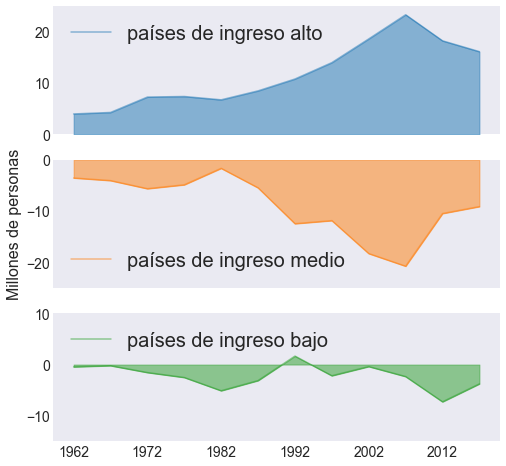

In [28]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=[8,8])

(migracion.T/1e6).plot.area(subplots=True, stacked=False, ax=axs)

axs[0].set_ylim([0,25])
axs[1].set_ylim([-25, 0])
axs[2].set_ylim([-15,10])
axs[2].set_xlabel('')

axs[0].legend(['países de ingreso alto'], loc='upper left', fontsize=20)
axs[1].legend(['países de ingreso medio'], loc='lower left', fontsize=20)
axs[2].legend(['países de ingreso bajo'], loc='upper left', fontsize=20)

axs[1].set_ylabel('Millones de personas')
fig.savefig('migracion-ingreso-total.pdf')

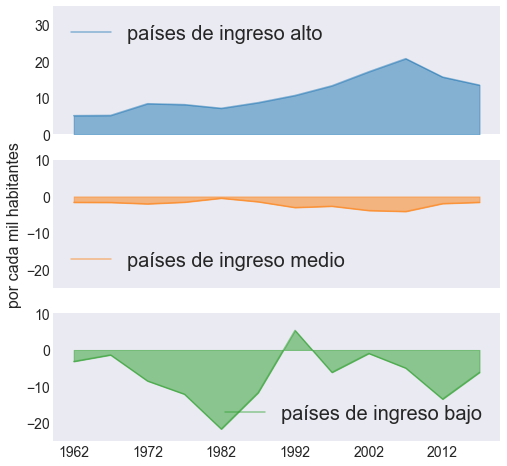

In [29]:
POP = wb.get_series('SP.POP.TOTL', simplify_index=True, id_or_value=True).unstack()

migracion2 = (1e3 * NETM / POP).loc[grupos[2:]].dropna(how='all', axis=1)

fig, axs = plt.subplots(3,1, sharex=True, figsize=[8,8])

(migracion2.T).plot.area(subplots=True, stacked=False, ax=axs)

axs[0].legend(['países de ingreso alto'], loc='upper left', fontsize=20)
axs[1].legend(['países de ingreso medio'], loc='lower left', fontsize=20)
axs[2].legend(['países de ingreso bajo'], loc='lower right', fontsize=20)
axs[2].set_xlabel('')


axs[0].set_ylim([0,35])
axs[1].set_ylim([-25, 10])
axs[2].set_ylim([-25,10])

axs[1].set_ylabel('por cada mil habitantes')
fig.savefig('migracion-ingreso-promedio.pdf')

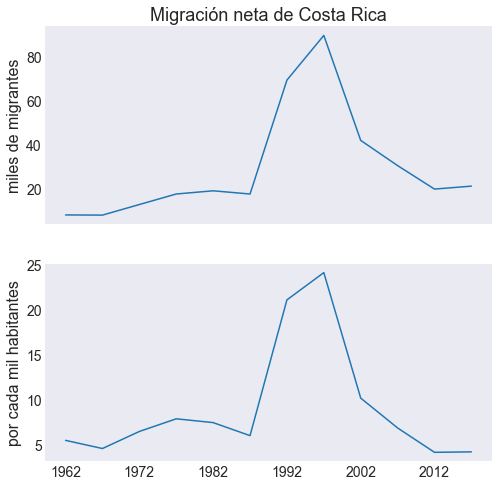

In [30]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=[8,8])
(NETM.loc['CRI'].dropna()/1000).plot(ax=axs[0])
(1000 * NETM.loc['CRI'] / POP.loc['CRI']).dropna().plot(ax=axs[1])

axs[0].set(ylabel='miles de migrantes', title = 'Migración neta de Costa Rica')
axs[1].set(ylabel='por cada mil habitantes', xlabel='')
fig.savefig('migracion-costa-rica.pdf')

### Mapa

In [31]:
migracion3 = pd.concat([NETM["2017"], POP["2017"]], axis=1)
migracion3.columns = ['NETM', 'POP']

In [32]:
migracion3.eval('NMR = NETM / POP * 1e3', inplace=True)

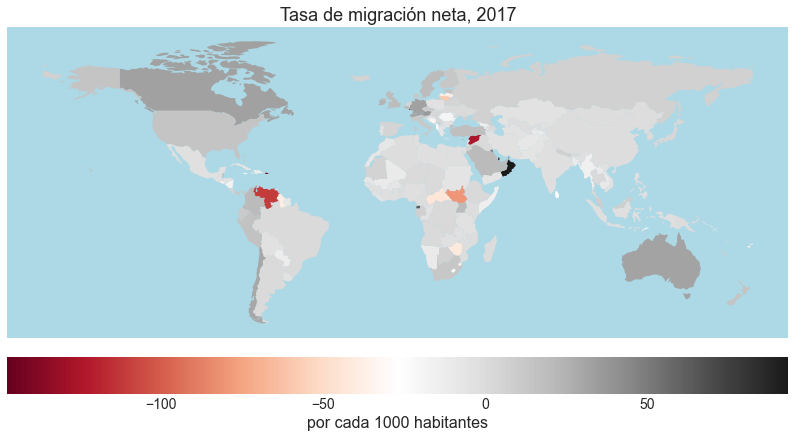

In [33]:
fig, axs = crear_map('NMR', migracion3,'Tasa de migración neta, 2017', "por cada 1000 habitantes", cmap="RdGy")
fig.savefig('map-migracion.pdf')

In [34]:
migracion3.NMR.dropna().sort_values().head(20)

Country
PRI   -147.335297
SYR   -124.999729
VEN   -111.087330
SSD    -79.829167
WSM    -71.729850
LTU    -57.948602
CAF    -43.515883
ZWE    -41.041263
STP    -40.567687
TON    -39.205114
GUY    -38.700082
LVA    -38.195946
SWZ    -37.129892
FJI    -35.338363
KIR    -35.031931
BIH    -32.201971
SLV    -31.729816
FSM    -26.906272
PSS    -26.207482
ALB    -24.360204
Name: NMR, dtype: float64

# Transición demográfica

## Estilizada

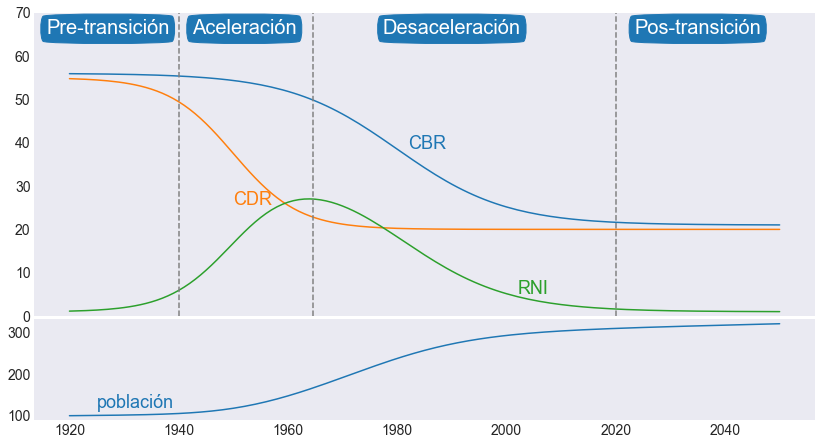

In [35]:
def logistic(x, mu=0, sigma=1, a=0, b=1):
    y = (x-mu) / sigma
    z = 1 / (1+np.exp(y))
    return a + (b-a)*z

cbr = lambda x: logistic(x, mu=1980, sigma=10, a=21, b=56)
cdr = lambda x: logistic(x, mu=1950, sigma=6, a=20, b=55)

años = np.arange(1920,2051)
stylized = pd.DataFrame({'CBR': cbr(años),
                         'CDR': cdr(años)},
                       index=años)

stylized.eval('RNI = CBR - CDR', inplace=True)

fig, (ax0, ax1) = plt.subplots(2,1,figsize=[14,7.5], gridspec_kw=dict(height_ratios=[3,1],hspace=0.015),sharex=True)
stylized.plot(ax=ax0)

opciones = dict(color='white', ha='center', fontsize=20, bbox=dict(boxstyle="round4", ec='C0',fc="C0"))


ax0.annotate('CBR', (1982, cbr(1980)), color='C0', fontsize=18)
ax0.annotate('CDR', (1950, cdr(1960)), color='C1', fontsize=18)
ax0.annotate('RNI', (2002, cbr(2000) - cdr(2000)), color='C2', fontsize=18)
ax0.legend([])
ax0.set_ylim(0,70)
ax0.axvline(1940, ls='--', color='gray')
ax0.axvline(1964.5, ls='--', color='gray')
ax0.axvline(2020, ls='--', color='gray')
ax0.annotate('Pre-transición', (1927,65), **opciones)
ax0.annotate('Aceleración', (1952,65), **opciones)
ax0.annotate('Desaceleración', (1990,65), **opciones)
ax0.annotate('Pos-transición', (2035,65), **opciones)

ax1.annotate('población', (1925, 120), color='C0', fontsize=18)

pob = (1 + stylized.RNI/1000).cumprod()
stylized['Poblacion'] = 100 * pob / pob.iloc[0]
stylized['Poblacion'].plot(ax=ax1)
fig.savefig('demographic_transition_example.pdf')

## Transición en Costa Rica

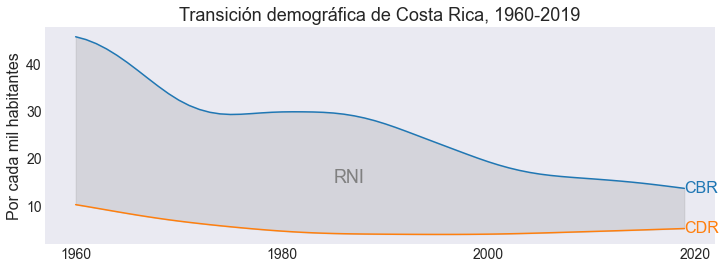

In [36]:
fig, ax = plt.subplots(figsize=[12,4])
temp = transi.swaplevel(axis=1)['CRI']
temp[['CBR','CDR']].plot(ax=ax)
ax.fill_between(temp.index, temp.CBR, temp.CDR, color='gray', alpha=0.2)
ax.set_xticks([0,20,40,60])

for i, gr in enumerate(['CBR','CDR']):
    ax.annotate(gr, (59, temp.loc['2019', gr]), fontsize=16, color=f'C{i}',va='center', ha='left')

ax.annotate('RNI', (25, 15), fontsize=18, color='gray')    
ax.legend([])
ax.set(xlabel='', ylabel='Por cada mil habitantes', title='Transición demográfica de Costa Rica, 1960-2019')
fig.savefig('RNI-CBR-CDR-Costa-Rica.pdf')

##  Transición en Alemania

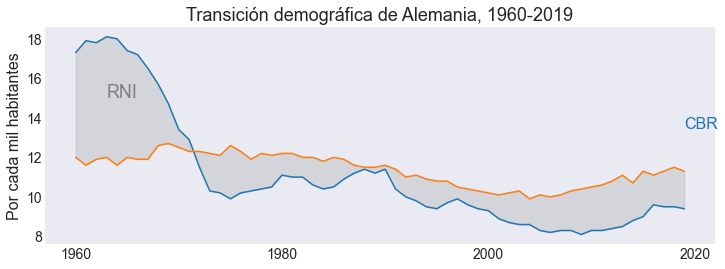

In [37]:
fig, ax = plt.subplots(figsize=[12,4])



transiDEU = pd.concat([wb.get_series(indic, simplify_index=True, country=['DEU'], id_or_value=True) for indic in ['SP.DYN.CBRT.IN','SP.DYN.CDRT.IN']], axis=1)
transiDEU.rename(columns={'SP.DYN.CBRT.IN':'CBR','SP.DYN.CDRT.IN':'CDR'}, inplace=True)

#temp = transi.swaplevel(axis=1)['DEU']
transiDEU[['CBR','CDR']].plot(ax=ax)
ax.fill_between(transiDEU.index, transiDEU.CBR, transiDEU.CDR, color='gray', alpha=0.2)
ax.set_xticks([0,20,40,60])

for i, gr in enumerate(['CBR','CDR']):
    ax.annotate(gr, (59, temp.loc['2019', gr]), fontsize=16, color=f'C{i}',va='center', ha='left')

ax.annotate('RNI', (3, 15), fontsize=18, color='gray')    
ax.legend([])
ax.set(xlabel='', ylabel='Por cada mil habitantes', title='Transición demográfica de Alemania, 1960-2019')
fig.savefig('RNI-CBR-CDR-Germany.pdf')

# Otros cálculos

In [38]:
popgrowth = np.log(POP.loc['WLD']).diff(10)*10

In [39]:
7752.8  * (1+1.13/100)**30

10860.724513359324

In [40]:
2020 + np.log(8/7.775) / np.log([1.013,1.0075,1.005])

array([2022.20870131, 2023.81799076, 2025.71986891])

In [41]:
2020 + np.log(9/7.775) / np.log([1.013,1.0075,1.005])

array([2031.32769956, 2039.58121369, 2049.3353186 ])